In [56]:
import json

In [57]:
with open("D:/Forecast/wind-forecast/data/WINDFORCAST.json") as f:
    data_for = json.load(f)

In [58]:
data_for


[{'publishTime': '2024-01-31T22:30:00Z',
  'startTime': '2024-01-31T23:00:00Z',
  'generation': 16909},
 {'publishTime': '2024-01-31T22:30:00Z',
  'startTime': '2024-02-01T00:00:00Z',
  'generation': 16341},
 {'publishTime': '2024-01-31T22:30:00Z',
  'startTime': '2024-02-01T01:00:00Z',
  'generation': 15630},
 {'publishTime': '2024-01-31T22:30:00Z',
  'startTime': '2024-02-01T02:00:00Z',
  'generation': 15049},
 {'publishTime': '2024-01-31T22:30:00Z',
  'startTime': '2024-02-01T03:00:00Z',
  'generation': 14787},
 {'publishTime': '2024-01-31T22:30:00Z',
  'startTime': '2024-02-01T04:00:00Z',
  'generation': 14303},
 {'publishTime': '2024-01-31T22:30:00Z',
  'startTime': '2024-02-01T05:00:00Z',
  'generation': 13746},
 {'publishTime': '2024-01-31T22:30:00Z',
  'startTime': '2024-02-01T06:00:00Z',
  'generation': 13139},
 {'publishTime': '2024-01-31T22:30:00Z',
  'startTime': '2024-02-01T07:00:00Z',
  'generation': 12561},
 {'publishTime': '2024-01-31T22:30:00Z',
  'startTime': '2024-02

In [59]:
with open("D:/Forecast/wind-forecast/data/WINDACT.json") as a:
    data_act = json.load(a)

In [60]:
data_act

[{'startTime': '2024-05-25T11:00:00Z', 'generation': 3721},
 {'startTime': '2024-05-25T10:30:00Z', 'generation': 3527},
 {'startTime': '2024-05-25T10:00:00Z', 'generation': 3472},
 {'startTime': '2024-05-25T09:30:00Z', 'generation': 3422},
 {'startTime': '2024-05-25T09:00:00Z', 'generation': 3041},
 {'startTime': '2024-05-25T08:30:00Z', 'generation': 2825},
 {'startTime': '2024-05-25T08:00:00Z', 'generation': 2595},
 {'startTime': '2024-05-25T07:30:00Z', 'generation': 2448},
 {'startTime': '2024-05-25T07:00:00Z', 'generation': 2373},
 {'startTime': '2024-05-25T06:30:00Z', 'generation': 2189},
 {'startTime': '2024-05-25T06:00:00Z', 'generation': 2010},
 {'startTime': '2024-05-25T05:30:00Z', 'generation': 1992},
 {'startTime': '2024-05-25T05:00:00Z', 'generation': 1945},
 {'startTime': '2024-05-25T04:30:00Z', 'generation': 1774},
 {'startTime': '2024-05-25T04:00:00Z', 'generation': 1730},
 {'startTime': '2024-05-25T03:30:00Z', 'generation': 1796},
 {'startTime': '2024-05-25T03:00:00Z', '

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

actual_df = pd.read_json('D:/Forecast/wind-forecast/data/WINDACT.json')
forecast_df = pd.read_json('D:/Forecast/wind-forecast/data/WINDFORCAST.json')

In [62]:
actual_df['startTime'] = pd.to_datetime(actual_df['startTime'])
forecast_df['publishTime'] = pd.to_datetime(forecast_df['publishTime'])
forecast_df['startTime'] = pd.to_datetime(forecast_df['startTime'])

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Resample actual_df to 60 minutes for easier merging as there is a difference of 1 hour between forecast startTimes and 30min difference between the startTime of actual
actual_df_resampled = actual_df.set_index('startTime').resample('60min').first().iloc[1:].reset_index()


# Merge using asof to get the closest previous actual data for each forecast startTime
forecast_df = forecast_df.sort_values(by='startTime')
actual_df_resampled = actual_df_resampled.sort_values(by='startTime')

merged_df = pd.merge_asof(forecast_df, actual_df_resampled, on='startTime', direction='backward', suffixes=('_forecast', '_actual'))

# Calculate the error
merged_df['error'] = merged_df['generation_forecast'] - merged_df['generation_actual']
merged_df['horizon'] = (merged_df['startTime'] - merged_df['publishTime']).dt.total_seconds() / 3600.0

# Remove rows where actual data is not available
merged_df = merged_df.dropna(subset=['generation_actual'])

# Temporal Error Analysis
temporal_error = merged_df.groupby('horizon')['error'].mean().reset_index()


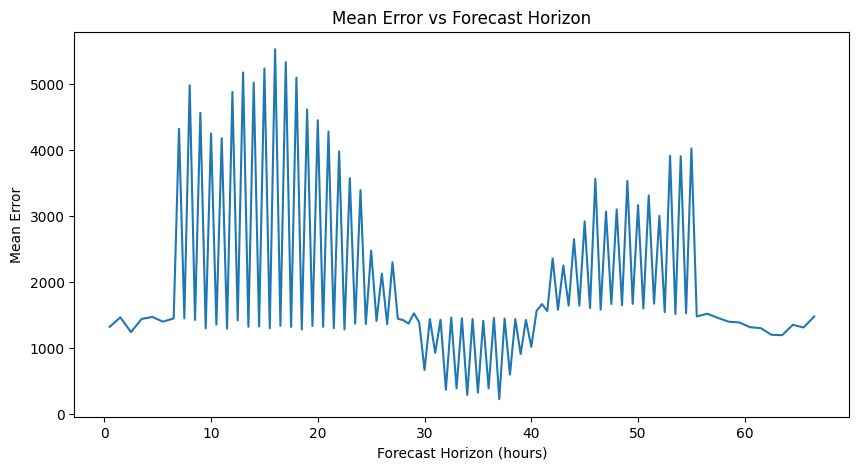

In [80]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=temporal_error, x='horizon', y='error')
plt.title('Mean Error vs Forecast Horizon')
plt.xlabel('Forecast Horizon (hours)')
plt.ylabel('Mean Error')
plt.show()


- The graph depicts the mean of wind generation forecasts as a function of the forecast horizon, measured in hours
- The crests and troughs in the plot are because of the variablility in the data, indicating that the forecast accuracy varies substantially across different forecast horizons.
- The forecast model's performance is inconsistent over time, necessitating improvements to achieve more stable and accurate predictions at various forecast horizons

C:\Users\risha\AppData\Local\Temp\ipykernel_392\2212137897.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_by_hour = merged_df.groupby('hour').apply(lambda x: mean_absolute_error(x['generation_actual'], x['generation_forecast'])).reset_index()


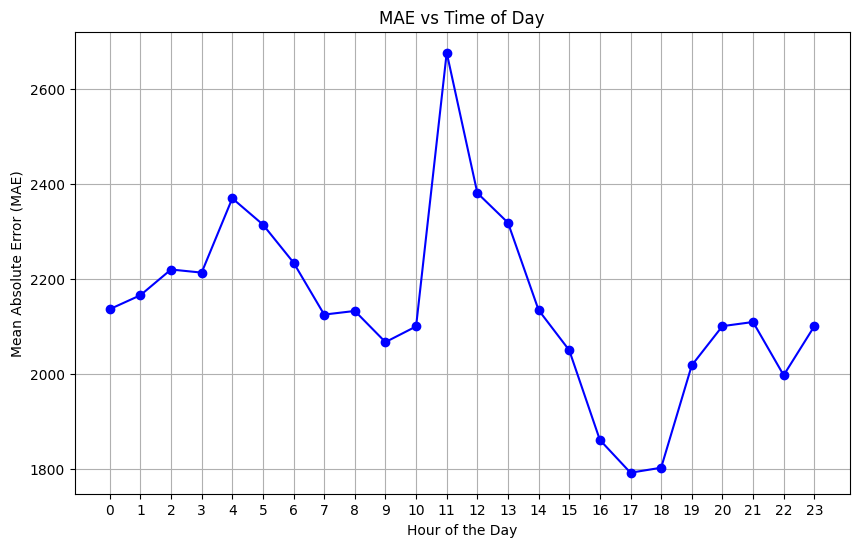

In [81]:
from sklearn.metrics import mean_absolute_error
merged_df['hour'] = merged_df['startTime'].dt.hour
mae_by_hour = merged_df.groupby('hour').apply(lambda x: mean_absolute_error(x['generation_actual'], x['generation_forecast'])).reset_index()
mae_by_hour.columns = ['hour', 'mae']

# Plot the MAE vs Time of Day
plt.figure(figsize=(10, 6))
plt.plot(mae_by_hour['hour'], mae_by_hour['mae'], marker='o', linestyle='-', color='b')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs Time of Day')
plt.grid(True)
plt.xticks(mae_by_hour['hour'])
plt.show()

- The graph displays the Mean Absolute Error (MAE) of wind generation forecasts plotted against different hours of the day
- Bimodal pattern is seen with two distinct peaks around 9 AM and 9 PM.Lowest values occur during mid-day hours (around 12 PM - 4 PM).It rises sharply in the early morning hours before the 9 AM peak.After the evening peak around 9 PM, it decreases gradually until early morning
-  The forecast model's accuracy is time-dependent, with higher errors observed in the late morning and lower errors in the late afternoon

Text(0.5, 0, 'Error')

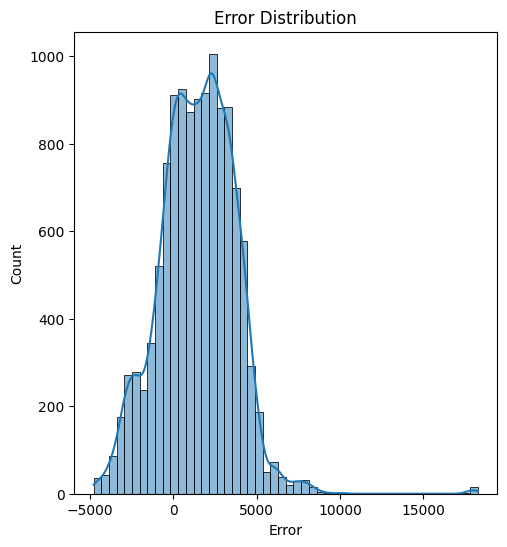

In [66]:
# Error Distribution Analysis
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(merged_df['error'], bins=50, kde=True)
plt.title('Error Distribution')
plt.xlabel('Error')

- The graph illustrates the distribution of forecast errors in wind generation, showing the frequency of different error magnitudes
- The error distribution is centered around zero, with most errors clustered between -2000 and 5000. The distribution is slightly right-skewed, indicating that positive errors (overestimations) are more frequent and larger than negative errors (underestimations)
- The forecast model generally performs well with errors concentrated around zero, but there is a tendency to overestimate wind generation. Addressing this bias could improve overall forecast accuracy

In [67]:
forecast_df['event_horizon'] = (forecast_df['startTime'] - forecast_df['publishTime']) / pd.Timedelta(hours=1)


In [75]:
mae = np.mean(np.abs(merged_df['error']))
rmse = np.sqrt(mse)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 2142.5263027295287
Root Mean Squared Error (RMSE): 2683.2686075502547


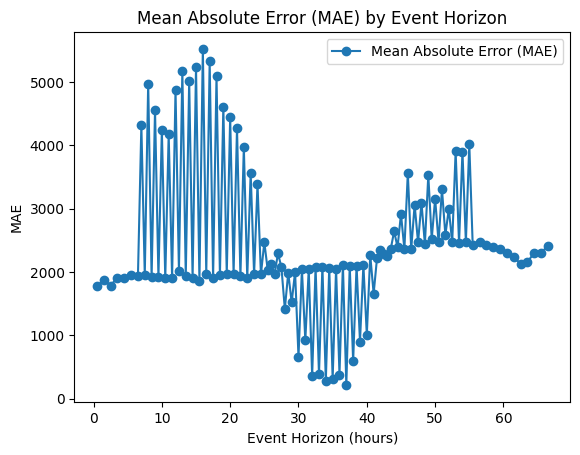

In [72]:
error_metrics['mae'].plot(marker='o', label='Mean Absolute Error (MAE)')
plt.title("Mean Absolute Error (MAE) by Event Horizon")
plt.xlabel("Event Horizon (hours)")
plt.ylabel("MAE")
plt.legend()

 -  The graph shows the Mean Absolute Error (MAE) of wind generation forecasts plotted against the forecast horizon, measured in hours
 - The MAE exhibits significant oscillations across different forecast horizons, with distinct peaks around the 10-20 hour range and a notable dip around the 30-hour mark. This indicates that forecast accuracy varies significantly depending on how far ahead the prediction is made
 - The forecast model's accuracy is inconsistent across different forecast horizons, with certain periods exhibiting much higher errorsns.

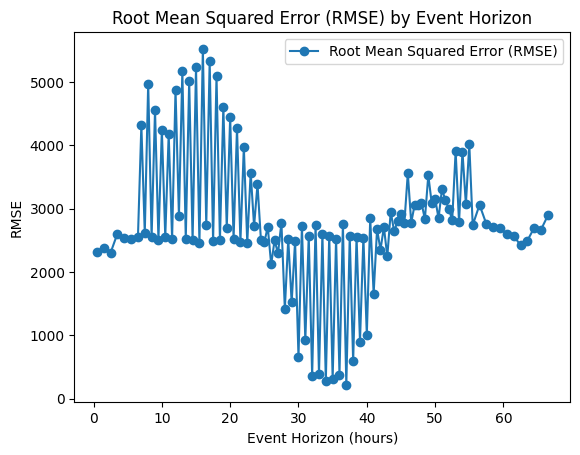

In [73]:
error_metrics['rmse'].plot(marker='o', label='Root Mean Squared Error (RMSE)')
plt.title("Root Mean Squared Error (RMSE) by Event Horizon")
plt.xlabel("Event Horizon (hours)")
plt.ylabel("RMSE")
plt.legend()

- The graph shows the Root Mean Squared Error (RMSE) of wind generation forecasts versus the forecast horizon in hours.
- RMSE peaks around the 10-20 hour range, indicating high errors, and dips around the 30-hour mark, showing lower errors.
- The forecast model's accuracy is inconsistent, with the highest errors in the short-term and relatively lower errors around 30 hours

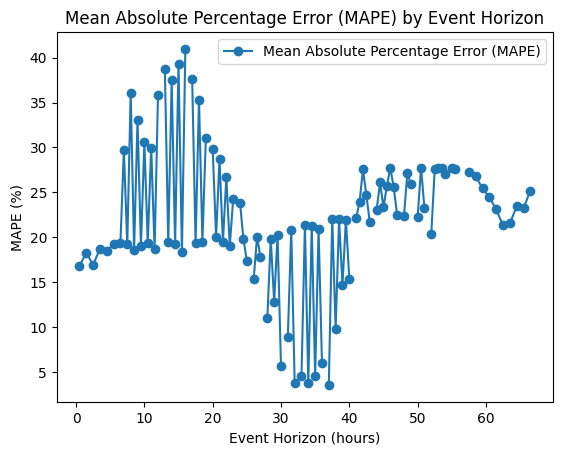

In [74]:

error_metrics['mape'].plot(marker='o', label='Mean Absolute Percentage Error (MAPE)')
plt.title("Mean Absolute Percentage Error (MAPE) by Event Horizon")
plt.xlabel("Event Horizon (hours)")
plt.ylabel("MAPE (%)")
plt.legend()

- The graph shows the Mean Absolute Percentage Error (MAPE) of wind generation forecasts versus the forecast horizon in hours
- MAPE peaks around the 10-20 hour range, indicating higher percentage errors, and dips around the 30-hour mark, showing lower percentage errors.
- The forecast model's percentage error varies significantly, with the highest errors in the short-term and relatively lower errors around 30 hours

# Overall analysis-


The wind generation forecast model's performance shows considerable variability across different forecast horizons and times of the day, leading to several key insights and areas for improvement.

1. **Forecast Horizon Analysis***
   - **High Short-Term Errors:** Significant fluctuations in Mean Error, RMSE, and MAPE within the 10-20 hour forecast horizon indicate that the model struggles with short-term predictions, likely due to rapid changes in wind conditions.
   - **Improved Medium-Term Accuracy:** A noticeable dip in errors around the 30-hour mark suggests that the model stabilizes and performs better in medium-term forecasts. This could be due to the model's ability to better capture underlying patterns over this horizon.

2. **Time of Day Influelity:** The MAE analysis shows higher forecast errors in the late morning and lower errors in the late afternoon, suggesting that the model's accuracy is influenced by diurnal wind pattern changes. This daily variability needs to be addressed for more consistent forecasting.

3. **Error Distri n Bias:** The error distribution is centered around zero but skewed to the right, indicating a tendency to overestimate wind generation. This bias must be corrected to improve forecast reltments and improvements.

### Conclusion:
The wind generation forecast model shows potential for accurate medium-term predictions but requires significant enhancements in short-term forecasting and daily variability handling. By addressing these key areas, the model's overall accuracy and reliability can be greatly improved, leading to better wind generation forecasts and more informed decision-making.